Using GPU : Quadro RTX 8000 (ID 0)


/state/partition1/job-64486977/ipykernel_2244088/2509314496.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1

LSTM-X   : q=4, hidden=70
LSTM-ΔX  : q(meta)=8, hidden=70 (window length=1 used here)


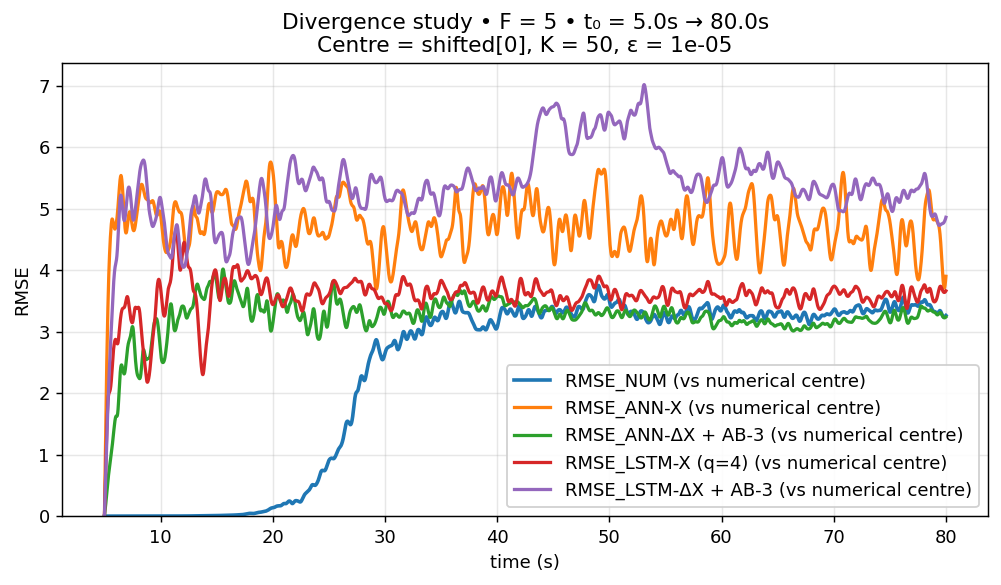


Final RMSE at t = T_END:
  NUM       : 3.2636e+00
  ANN-X     : 3.9008e+00
  ANN-ΔX    : 3.2393e+00
  LSTM-X    : 3.6633e+00  (q=4)
  LSTM-ΔX   : 4.8605e+00


In [2]:
#!/usr/bin/env python3
# =============================================================================
#  Aggregate "old-style" divergence study • single-implicit
#  ---------------------------------------------------------------------------
#  • One plot with 5 curves (all share the same perturbation ensemble at t0=5s):
#      1) RMSE_NUM(t)          – numerical ensemble (RK4) vs numerical centre
#      2) RMSE_ANN_X(t)        – ANN-X (direct next-state) vs numerical centre
#      3) RMSE_ANN_ΔX(t)       – ANN-ΔX (+ AB-3 in z-space) vs numerical centre
#      4) RMSE_LSTM_X(t)       – LSTM-X (windowed direct) vs numerical centre
#      5) RMSE_LSTM_ΔX(t)      – LSTM-ΔX (+ AB-3 in z-space) vs numerical centre
#
#  • Centre state at t0 is taken from a shifted trajectory (so LSTM-X can use
#    centre-history seeding for its first q-1 frames; last frame is W0 member).
#  • ΔX models use AB-3 in normalised space (Euler → AB-2 → AB-3).
#  • All curves are computed against the same numerical centre trajectory.
#  • GPU if available; otherwise 14 CPU threads.
#
#  ADAPT TO OTHER FORCINGS:
#    - Change FORCE, SHIFTED_FILE, TRAIN_FILE, and checkpoint paths below.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ───────────────────────────── USER PARAMETERS ─────────────────────────────
# Force and time window
FORCE        = 5.0            # ← set to 10.0 or 15.0 for other forcings
DT           = 0.005
T0           = 5.0
T_END        = 80.0           # can extend, but RAM use grows if you store full paths

# Data & checkpoints (set these explicitly; no auto name construction)
SHIFTED_FILE = "shifted_force5_data.npz"     # unseen test set (for centre history)
TRAIN_FILE   = "force_5_data.npz"            # for μ/σ fallback if a ckpt lacks them

CKPT_ANN_X   = "standard_early_stopping_force5_annX.pt"        # ANN-X (direct next-state)
CKPT_ANN_dX  = "standard_early_stopping_force5_ann.pt"            # ANN-ΔX
CKPT_LSTM_X  = "standard_early_stopping_force5_LSTM_H70_q4.pt"    # LSTM-X (q auto)
CKPT_LSTM_dX = "standard_early_stopping_force5_LSTM_dX_H70_q8.pt" # LSTM-ΔX (q not used)

# If the LSTM-X checkpoint lacks 'lookback' and filename lacks _q{q}.pt, set override:
Q_OVERRIDE_LSTMX = None

# Ensemble definition (shared by all five rollouts)
K            = 50
EPS          = 1e-5
SEED         = 0
RADIUS       = EPS * math.sqrt(5.0/3.0)
CENTRE_TRAJ_INDEX = 0     # which shifted trajectory provides centre & its history
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────── DEVICE / THREADS ────────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count()))
    print(f"Using CPU : {torch.get_num_threads()} threads")

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────── L96 (Torch) utilities ───────────────────────────
def l96_rhs(x, F=FORCE):
    # x shape: (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x)
    k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2)
    k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

# ───────────────────────── Helpers: ckpt parsing / models ─────────────────
def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    # Try common layouts
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        # direct state-dict? (all tensors)
        if len(obj) > 0 and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        # nested dicts
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None:
                    return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from state_dict.")

# MLP for ANN-X / ANN-ΔX (same architecture you trained)
def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

# Load ANN-X or ANN-ΔX checkpoint -> (model, mu_t, sd_t, predicts_delta_flag)
def load_ann_ckpt(path, train_fallback, predicts_delta: bool):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std", None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu, dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t, predicts_delta

# LSTM-X
class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):          # w: (B, q, n)
        y, _ = self.lstm(w)
        return self.head(y[:, -1]) # (B, n)  next-state (z-space)

# LSTM-ΔX
class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):          # w: (B, 1, n) in our old-style divergence
        y, _ = self.lstm(w)
        return self.head(y[:, -1]) # (B, n)  ΔX̂ (z-space)

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None:
        q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None:
        hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std", None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu, dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None:
        hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std", None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu, dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    # q (if present) is meta only; we use window length 1 here to match "old study"
    q_meta = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q_meta = int(ck[k]); break
                except: pass
    return net, mu_t, sd_t, q_meta, hidden

# ───────────────────────── Load data & define centre/ensemble ────────────
shifted = np.load(SHIFTED_FILE)
X_shift_all = shifted["X"].astype(np.float32)            # (traj, step, 36)
N_TRAJ, N_STEPS, N = X_shift_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

centre_traj = X_shift_all[CENTRE_TRAJ_INDEX]
x0_centre   = centre_traj[i0].copy()                    # (36,)

# One shared perturbation ensemble at t0 (used by ALL methods)
rng = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

# ───────────────────────── Load all four models (+ μ/σ) ──────────────────
ann_x,  mu_annx, sd_annx, _         = load_ann_ckpt (CKPT_ANN_X,  TRAIN_FILE, predicts_delta=False)
ann_dx, mu_anndx, sd_anndx, _       = load_ann_ckpt (CKPT_ANN_dX, TRAIN_FILE, predicts_delta=True)
lstm_x, mu_lx,   sd_lx,   q_lx, Hx  = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE)
lstm_dx,mu_ldx,  sd_ldx,  q_ld, Hd  = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print(f"LSTM-ΔX  : q(meta)={q_ld}, hidden={Hd} (window length=1 used here)")

# ───────────────────────── AB-3 helper (z-space) ─────────────────────────
def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

# ───────────────────────── Streaming rollouts & RMSE(t) ──────────────────
# We integrate all methods in lockstep; at each step s we compute RMSE(t_s)
# vs the numerical centre. No need to store full trajectories (saves RAM).

# Initial states at t0
num_state     = torch.from_numpy(W0).to(DEVICE)                        # (B,36)
annx_norm     = (num_state - mu_annx) / sd_annx                        # (B,36)
anndx_norm    = (num_state - mu_anndx) / sd_anndx                      # (B,36)
lstdx_norm    = (num_state - mu_ldx) / sd_ldx                          # (B,36)

# LSTM-X window seeding: "centre-history" for first q-1 frames +
# last frame = each member's x(t0)
if q_lx > 1:
    hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
    win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
    win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
    win_lx[:,  q_lx-1, :] = num_state
    win_lx = (win_lx - mu_lx) / sd_lx
else:
    win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)                # (B,1,36)

# AB-3 memories for ΔX models
dx1_prev_ann  = dx2_prev_ann  = None
dx1_prev_lstm = dx2_prev_lstm = None

# Allocate RMSE arrays
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64)   # ANN-X
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64)   # ANN-ΔX
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64)   # LSTM-X
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64)   # LSTM-ΔX

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36), base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# Time loop (includes s=0)
for s in range(T_steps + 1):
    # ---- 1) compute RMSEs at current time s ----
    base_num = num_state[0]                                  # (36,)

    # Numerical
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    # ANN-X (direct) : state is ANN's last z-output → denorm to phys
    annx_phys = annx_norm * sd_annx + mu_annx
    rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    # ANN-ΔX (+AB-3) : state is current z-state → denorm to phys
    anndx_phys = anndx_norm * sd_anndx + mu_anndx
    rmse_adx[s] = rmse_vs_centre(anndx_phys, base_num)

    # LSTM-X (direct): last frame of window → denorm to phys
    lx_last_norm = win_lx[:, -1, :]                          # (B,36)
    lx_phys      = lx_last_norm * sd_lx + mu_lx
    rmse_lx[s]   = rmse_vs_centre(lx_phys, base_num)

    # LSTM-ΔX (+AB-3): state is current z-state → denorm to phys
    lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
    rmse_ldx[s] = rmse_vs_centre(lstdx_phys, base_num)

    # ---- 2) advance all methods by one step (skip after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    # ANN-X (direct): next_norm = f(prev_norm)
    with torch.no_grad():
        next_norm_annx = ann_x(annx_norm)                    # (B,36)
    annx_norm = next_norm_annx

    # ANN-ΔX (+AB-3): ΔX̂_z → AB-3 combine in z-space
    with torch.no_grad():
        dx1_ann = ann_dx(anndx_norm)                         # (B,36)
    step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
    anndx_norm = anndx_norm + step_ann
    dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

    # LSTM-X (direct): next_norm = f(window); slide window
    with torch.no_grad():
        y_lx = lstm_x(win_lx)                                # (B,36) next-state (z)
    if win_lx.shape[1] > 1:
        win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
    else:
        win_lx[:, 0, :] = y_lx

    # LSTM-ΔX (+AB-3): we follow "old study" window=1 logic
    with torch.no_grad():
        dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))          # (B,36) ΔX̂_z
    step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
    lstdx_norm = lstdx_norm + step_lstm
    dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ───────────────────────── Plot: 5 curves on one chart ───────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)
plt.plot(t_axis, rmse_num,  lw=2.0, label="RMSE_NUM (vs numerical centre)")
plt.plot(t_axis, rmse_ax,   lw=1.8, label="RMSE_ANN-X (vs numerical centre)")
plt.plot(t_axis, rmse_adx,  lw=1.8, label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
plt.plot(t_axis, rmse_lx,   lw=1.8, label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
plt.plot(t_axis, rmse_ldx,  lw=1.8, label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
plt.title(f"Divergence study • F = {int(FORCE)} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[{CENTRE_TRAJ_INDEX}], K = {K}, ε = {EPS:g}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

print("\nFinal RMSE at t = T_END:")
print(f"  NUM       : {rmse_num[-1]:.4e}")
print(f"  ANN-X     : {rmse_ax [-1]:.4e}")
print(f"  ANN-ΔX    : {rmse_adx[-1]:.4e}")
print(f"  LSTM-X    : {rmse_lx [-1]:.4e}  (q={q_lx})")
print(f"  LSTM-ΔX   : {rmse_ldx[-1]:.4e}")
